In [189]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON
import matplotlib.pyplot as plt

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [191]:
# font
plt.rcParams['font.family'] = 'Arial'

In [206]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [122]:
api_key = 'xxxxx'

In [123]:
channel_ids = ['UCEwl20VxZ3AwOgiKMZtI1GQ',
               #more channels here
              ]

In [14]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
      api_service_name, api_version, developerKey=api_key)

In [124]:
def get_channel_stats(youtube,channel_ids):
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    #loop through items
    for item in response['items']:
        data = {'channelName':item['snippet']['title'],
                'subscribers':item['statistics']['subscriberCount'],
                'views':item['statistics']['viewCount'],
                'totalVideos':item['statistics']['videoCount'],
                'playlistId':item['contentDetails']['relatedPlaylists']['uploads'],
            }
        all_data.append(data)
    return pd.DataFrame(all_data)


In [125]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [126]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,La Capital,9410000,1990424894,335,UUEwl20VxZ3AwOgiKMZtI1GQ


In [119]:
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 40
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [120]:
video_ids = get_video_ids(youtube, playlist_id)

In [121]:
len(video_ids)

335

In [130]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [131]:
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,gJDJZGV_pKM,La Capital,Freidora de Aire Pero con Humo | La Capital,Contacto directo: oscarlacapital@gmail.com\nPa...,"[ninja firewood, la capital, costillas de res,...",2023-08-28T21:00:16Z,1015531,59066,None,1586,PT11M47S,hd,false
1,4DwdEaMDTRo,La Capital,Picaña Infierno al Mezcal | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[picana a la parrilla, salsa negra, salsa haba...",2023-08-15T21:00:03Z,1475548,83703,None,1316,PT8M23S,hd,false
2,mPufqoACksA,La Capital,Taco y Torta al Pastor | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[tacos al pastor, al pastor receta, al pastor ...",2023-07-31T21:00:32Z,2916748,128762,None,1664,PT11M23S,hd,false
3,xiYcwrnndlA,La Capital,Aguachile de Ribeye pero Wagyu | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[aguachile, la capital, chiltepin, ribeye asad...",2023-07-19T21:00:29Z,1753048,83998,None,1555,PT10M25S,hd,false
4,b3s6ZkmC8ks,La Capital,Todo lo rico de Japón | La Capital,Contacto directo: oscarlacapital@gmail.com\nLi...,"[comida japonesa, la capital, viajar japon, su...",2023-07-13T21:00:16Z,1999100,90944,None,1265,PT17M57S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,qQ1P2JPf_IU,La Capital,Queso fundido con Chorizo | Botana Fácil | La ...,Gran opción para botanear antes de una carne a...,"[queso fundido, queso gratinado, con chorizo, ...",2016-08-27T16:30:01Z,3777028,155051,None,3018,PT7M9S,hd,false
331,VcciYKH8hAM,La Capital,Verdaderos Camarones A LA DIABLA | La Capital,Después de varias malas experiencias en restau...,"[camarones a la diabla, camarones, mexican sea...",2016-08-21T16:30:00Z,3848429,122473,None,2704,PT5M56S,hd,false
332,0uDlaSepHL0,La Capital,Chilaquiles Verdes con Huevo | La Capital,El mejor desayuno y mi favorito siempre! Chila...,"[chilaquiles, chilaquiles verdes, chile habane...",2016-08-14T16:45:04Z,3877129,122206,None,5152,PT9M55S,hd,false
333,TtaybghWcow,La Capital,Pechuga Rellena de Camaron *ENVUELTA EN TOCINO...,Video de Aguachiles: https://goo.gl/nsRHPd\n\n...,"[pechuga de pollo, pechuga rellena, camarones,...",2016-08-10T14:51:50Z,1758295,70942,None,2707,PT12M36S,hd,false


In [ ]:
## Data pre-processing 

In [132]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [133]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [169]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [183]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(str(x))) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [184]:
# convert duration to seconds

video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [185]:
video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,0 days 00:11:47,PT11M47S
1,0 days 00:08:23,PT8M23S
2,0 days 00:11:23,PT11M23S
3,0 days 00:10:25,PT10M25S
4,0 days 00:17:57,PT17M57S
...,...,...
330,0 days 00:07:09,PT7M9S
331,0 days 00:05:56,PT5M56S
332,0 days 00:09:55,PT9M55S
333,0 days 00:12:36,PT12M36S


In [186]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [187]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,gJDJZGV_pKM,La Capital,Freidora de Aire Pero con Humo | La Capital,Contacto directo: oscarlacapital@gmail.com\nPa...,"[ninja firewood, la capital, costillas de res,...",2023-08-28 21:00:16+00:00,1015531.0,59066.0,NaN,1586.0,PT11M47S,hd,false,Monday,0 days 00:11:47,7
1,4DwdEaMDTRo,La Capital,Picaña Infierno al Mezcal | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[picana a la parrilla, salsa negra, salsa haba...",2023-08-15 21:00:03+00:00,1475548.0,83703.0,NaN,1316.0,PT8M23S,hd,false,Tuesday,0 days 00:08:23,9
2,mPufqoACksA,La Capital,Taco y Torta al Pastor | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[tacos al pastor, al pastor receta, al pastor ...",2023-07-31 21:00:32+00:00,2916748.0,128762.0,NaN,1664.0,PT11M23S,hd,false,Monday,0 days 00:11:23,9
3,xiYcwrnndlA,La Capital,Aguachile de Ribeye pero Wagyu | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[aguachile, la capital, chiltepin, ribeye asad...",2023-07-19 21:00:29+00:00,1753048.0,83998.0,NaN,1555.0,PT10M25S,hd,false,Wednesday,0 days 00:10:25,8
4,b3s6ZkmC8ks,La Capital,Todo lo rico de Japón | La Capital,Contacto directo: oscarlacapital@gmail.com\nLi...,"[comida japonesa, la capital, viajar japon, su...",2023-07-13 21:00:16+00:00,1999100.0,90944.0,NaN,1265.0,PT17M57S,hd,false,Thursday,0 days 00:17:57,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,qQ1P2JPf_IU,La Capital,Queso fundido con Chorizo | Botana Fácil | La ...,Gran opción para botanear antes de una carne a...,"[queso fundido, queso gratinado, con chorizo, ...",2016-08-27 16:30:01+00:00,3777028.0,155051.0,NaN,3018.0,PT7M9S,hd,false,Saturday,0 days 00:07:09,25
331,VcciYKH8hAM,La Capital,Verdaderos Camarones A LA DIABLA | La Capital,Después de varias malas experiencias en restau...,"[camarones a la diabla, camarones, mexican sea...",2016-08-21 16:30:00+00:00,3848429.0,122473.0,NaN,2704.0,PT5M56S,hd,false,Sunday,0 days 00:05:56,19
332,0uDlaSepHL0,La Capital,Chilaquiles Verdes con Huevo | La Capital,El mejor desayuno y mi favorito siempre! Chila...,"[chilaquiles, chilaquiles verdes, chile habane...",2016-08-14 16:45:04+00:00,3877129.0,122206.0,NaN,5152.0,PT9M55S,hd,false,Sunday,0 days 00:09:55,13
333,TtaybghWcow,La Capital,Pechuga Rellena de Camaron *ENVUELTA EN TOCINO...,Video de Aguachiles: https://goo.gl/nsRHPd\n\n...,"[pechuga de pollo, pechuga rellena, camarones,...",2016-08-10 14:51:50+00:00,1758295.0,70942.0,NaN,2707.0,PT12M36S,hd,false,Wednesday,0 days 00:12:36,19


# EDA

## Top-performing videos

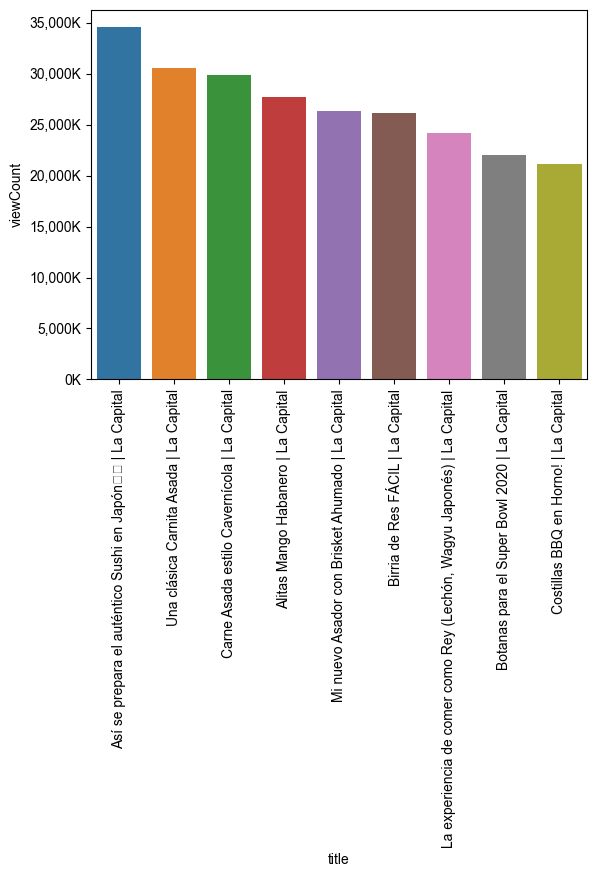

In [207]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Low-performing videos

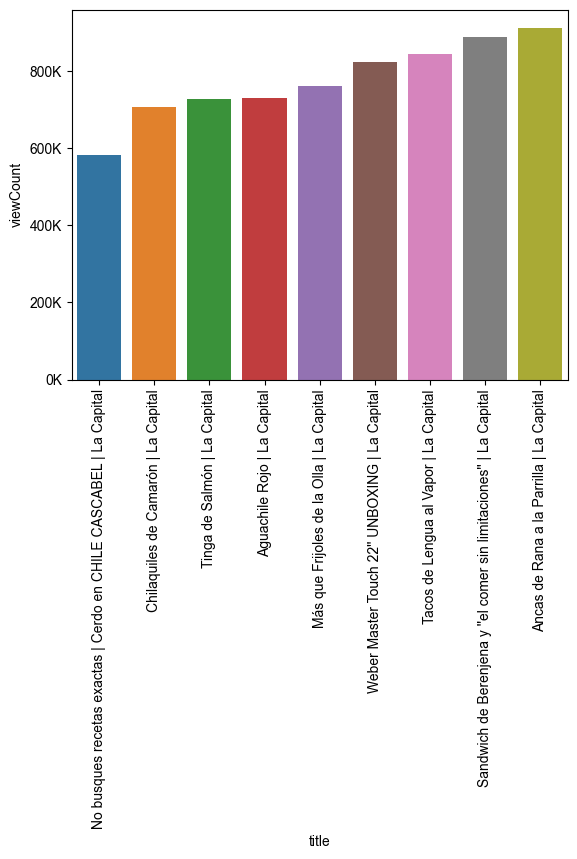

In [203]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Views vs. likes and comments

<Axes: xlabel='likeCount', ylabel='viewCount'>

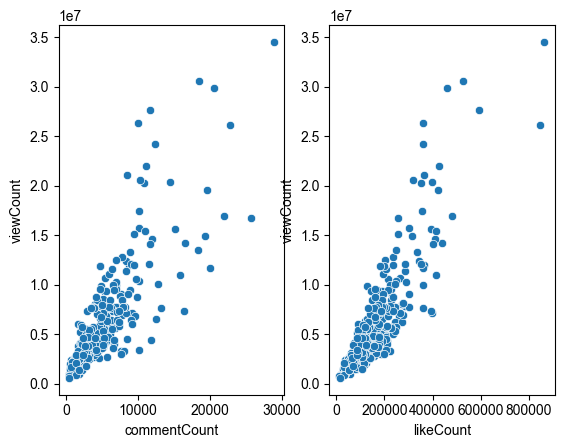

In [204]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

## Video duration


<Axes: xlabel='durationSecs', ylabel='Count'>

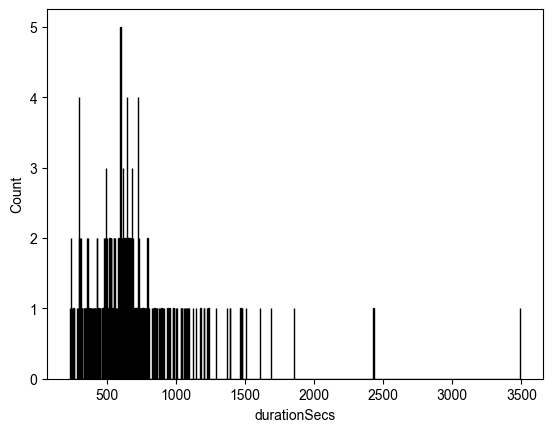

In [215]:
sns.histplot(data = video_df, x = 'durationSecs', bins=60, linewidth=1)

## Wordcloud for video titles

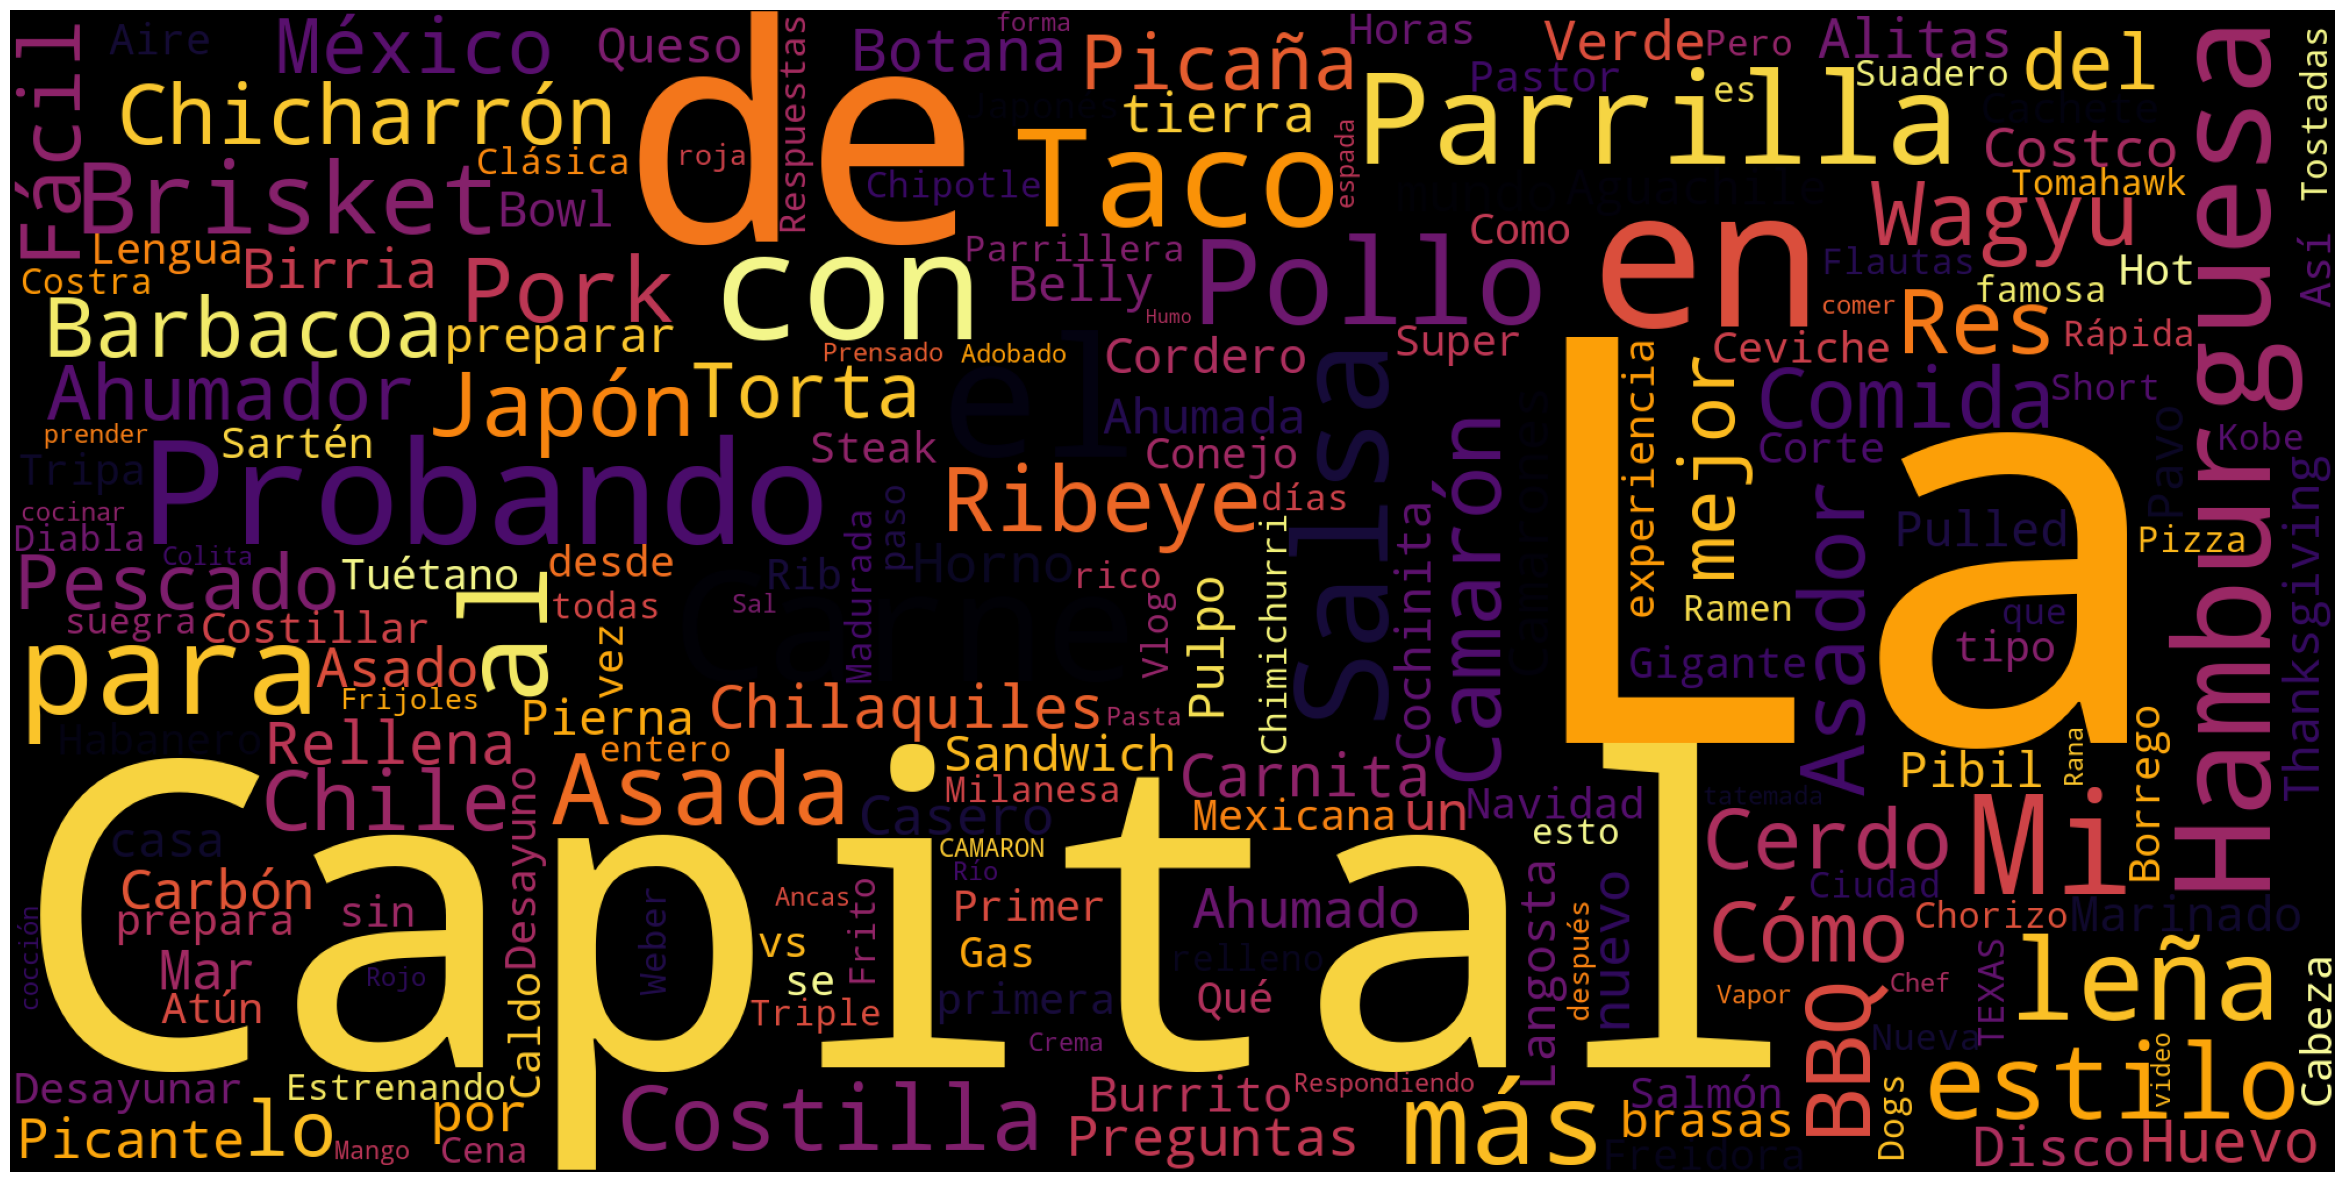

In [218]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='inferno', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)